## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP (Gross Domestic Product) per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [540]:
# Import libraries
import numpy as np
import pandas as pd
from scipy.stats import mstats

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

## Load and explore data

In [541]:
# Import the dataset
country_df = pd.read_csv('Country-data.csv')
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [544]:
# Check the shape
print(f"Dataset's shape: {country_df.shape}")

Dataset's shape: (167, 10)


In [545]:
# Check datatypes & counts
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [546]:
# Get descriptive statistics
country_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [547]:
# Identify any missing data
missing_data_rows = []
total_rows = len(country_df)

for num in country_df.columns:
    missing_values_count = country_df[num].isnull().sum()
    percentage_missing_per_column = round((missing_values_count / total_rows) * 100)
    missing_data_rows.append({'Feature': num,'Missing Values Count': missing_values_count,'Percentage Missing': f"{percentage_missing_per_column}%"})

# convert the list of dictionaries into a dataFrame
missing_output_df = pd.DataFrame(missing_data_rows)
missing_output_df

,Feature,Missing Values Count,Percentage Missing
0,country,0,0%
1,child_mort,0,0%
2,exports,0,0%
3,health,0,0%
4,imports,0,0%
5,income,0,0%
6,inflation,0,0%
7,life_expec,0,0%
8,total_fer,0,0%
9,gdpp,0,0%


Since there are no missing values in the datasets, there is no need for imputation.

## Preprocessing and Feature Selection

In [548]:
# Store the country column separately
countries = country_df['country']

# Drop any non-numeric features (columns)
country_df = country_df.drop(columns='country', axis=1)

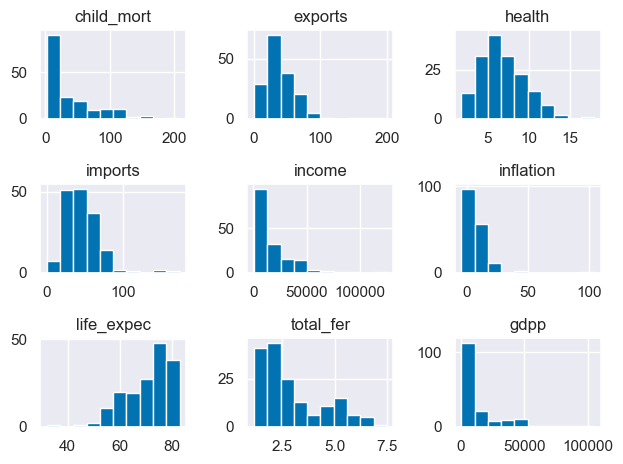

In [549]:
# plot the distributions of numeric features
country_df.hist()
plt.tight_layout()

The distribution of the features is non-Gaussian. Therefore, all features will be normalised using **MinMaxScaler()** at the later stage.

<Axes: >

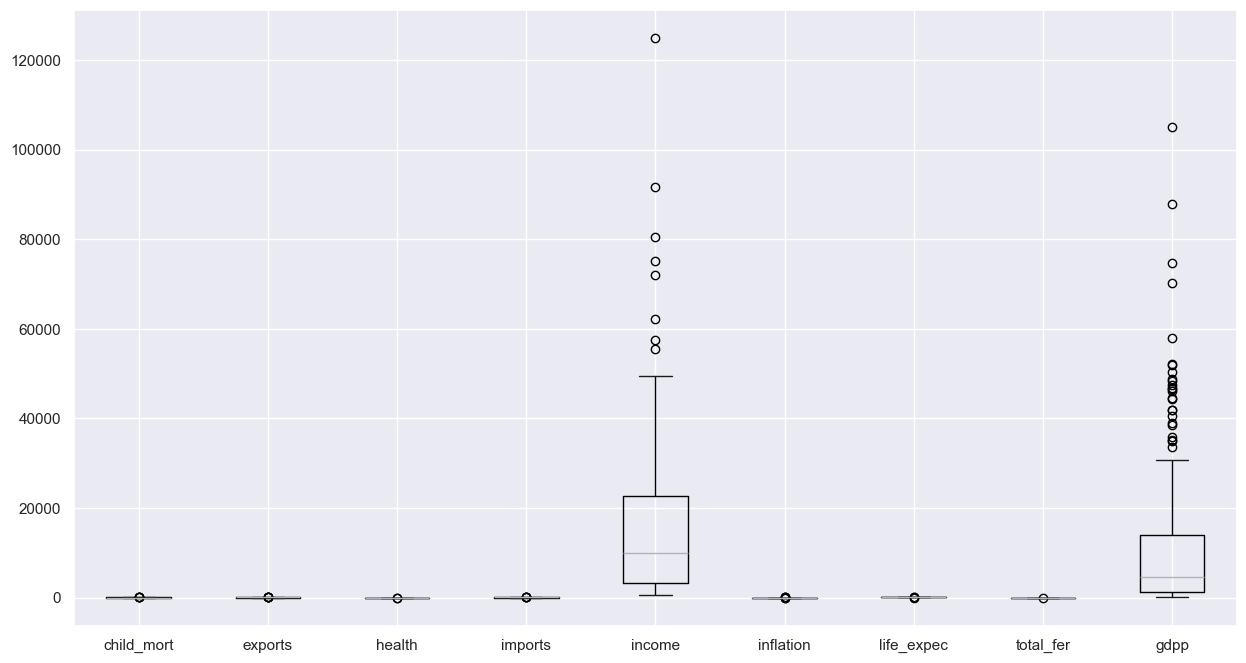

In [550]:
# plot the distribution of the features before applying the scaler along with their outliers
country_df.boxplot(figsize=(15, 8))

There appear to be outliers in several features that need to be addressed using winsorization in the following cell.

<Axes: >

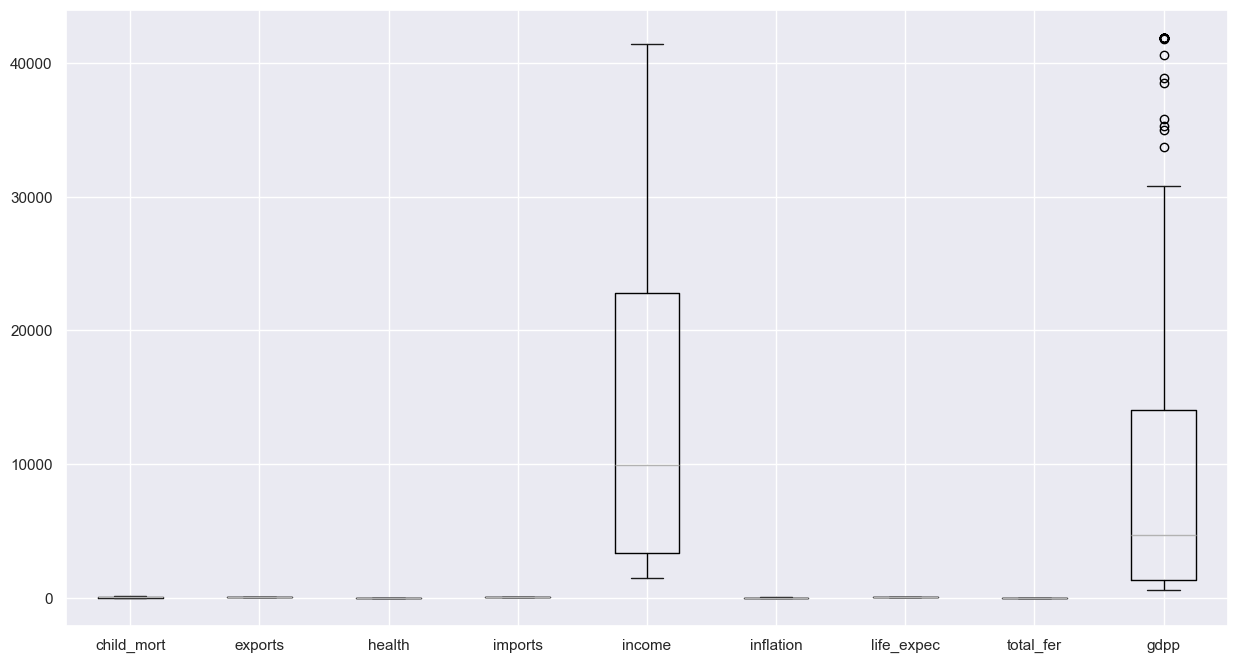

In [551]:
# Apply winsorization to each column and plot the effect of it on the outliers
for column in country_df:
    country_df[column] = mstats.winsorize(country_df[column], limits=(0.10, 0.10))
country_df.boxplot(figsize=(15, 8))

In [552]:
# Create a correlation map of features to explore relationships between features
corr_matrix = country_df.corr()
corr_matrix

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.000000,-0.365953,-0.251319,-0.126886,-0.670659,0.325872,-0.898769,0.897084,-0.588624
exports,-0.365953,1.000000,-0.116157,0.571846,0.461568,-0.066933,0.316822,-0.341610,0.339515
health,-0.251319,-0.116157,1.000000,0.114501,0.292929,-0.367056,0.269592,-0.236120,0.399386
imports,-0.126886,0.571846,0.114501,1.000000,-0.017712,-0.293655,0.025053,-0.140064,-0.043373
income,-0.670659,0.461568,0.292929,-0.017712,1.000000,-0.253061,0.744321,-0.613750,0.947869
inflation,0.325872,-0.066933,-0.367056,-0.293655,-0.253061,1.000000,-0.344778,0.352184,-0.341645
life_expec,-0.898769,0.316822,0.269592,0.025053,0.744321,-0.344778,1.000000,-0.831782,0.692594
total_fer,0.897084,-0.341610,-0.236120,-0.140064,-0.613750,0.352184,-0.831782,1.000000,-0.529613
gdpp,-0.588624,0.339515,0.399386,-0.043373,0.947869,-0.341645,0.692594,-0.529613,1.000000


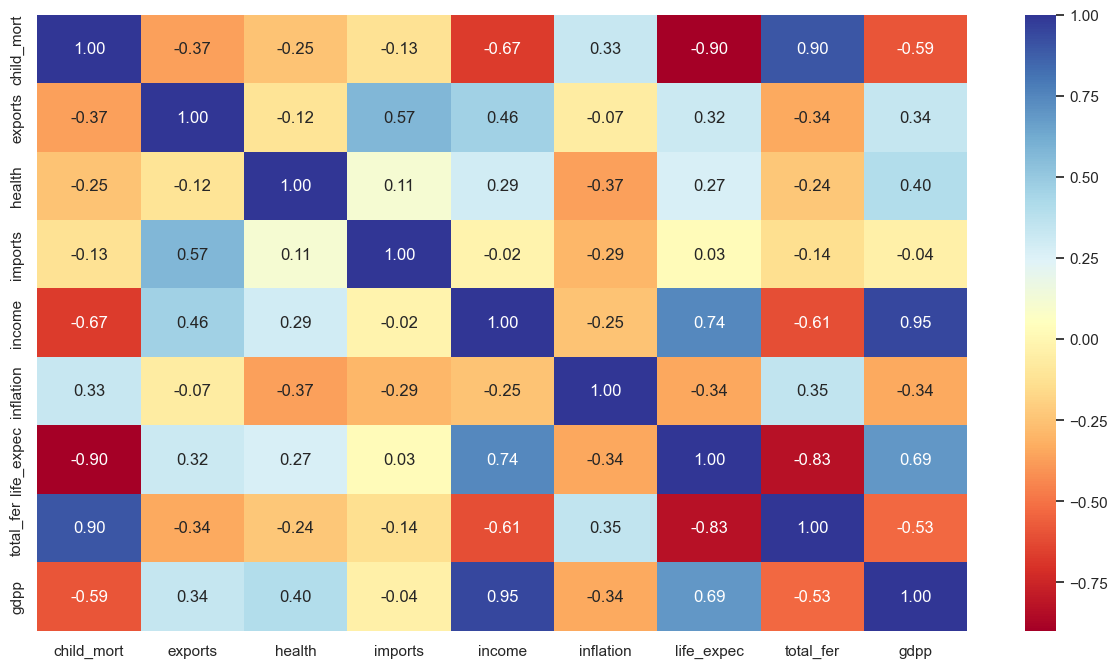

In [553]:
plt.figure(figsize=(15, 8))  # adjust width and height as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdYlBu")
plt.show()

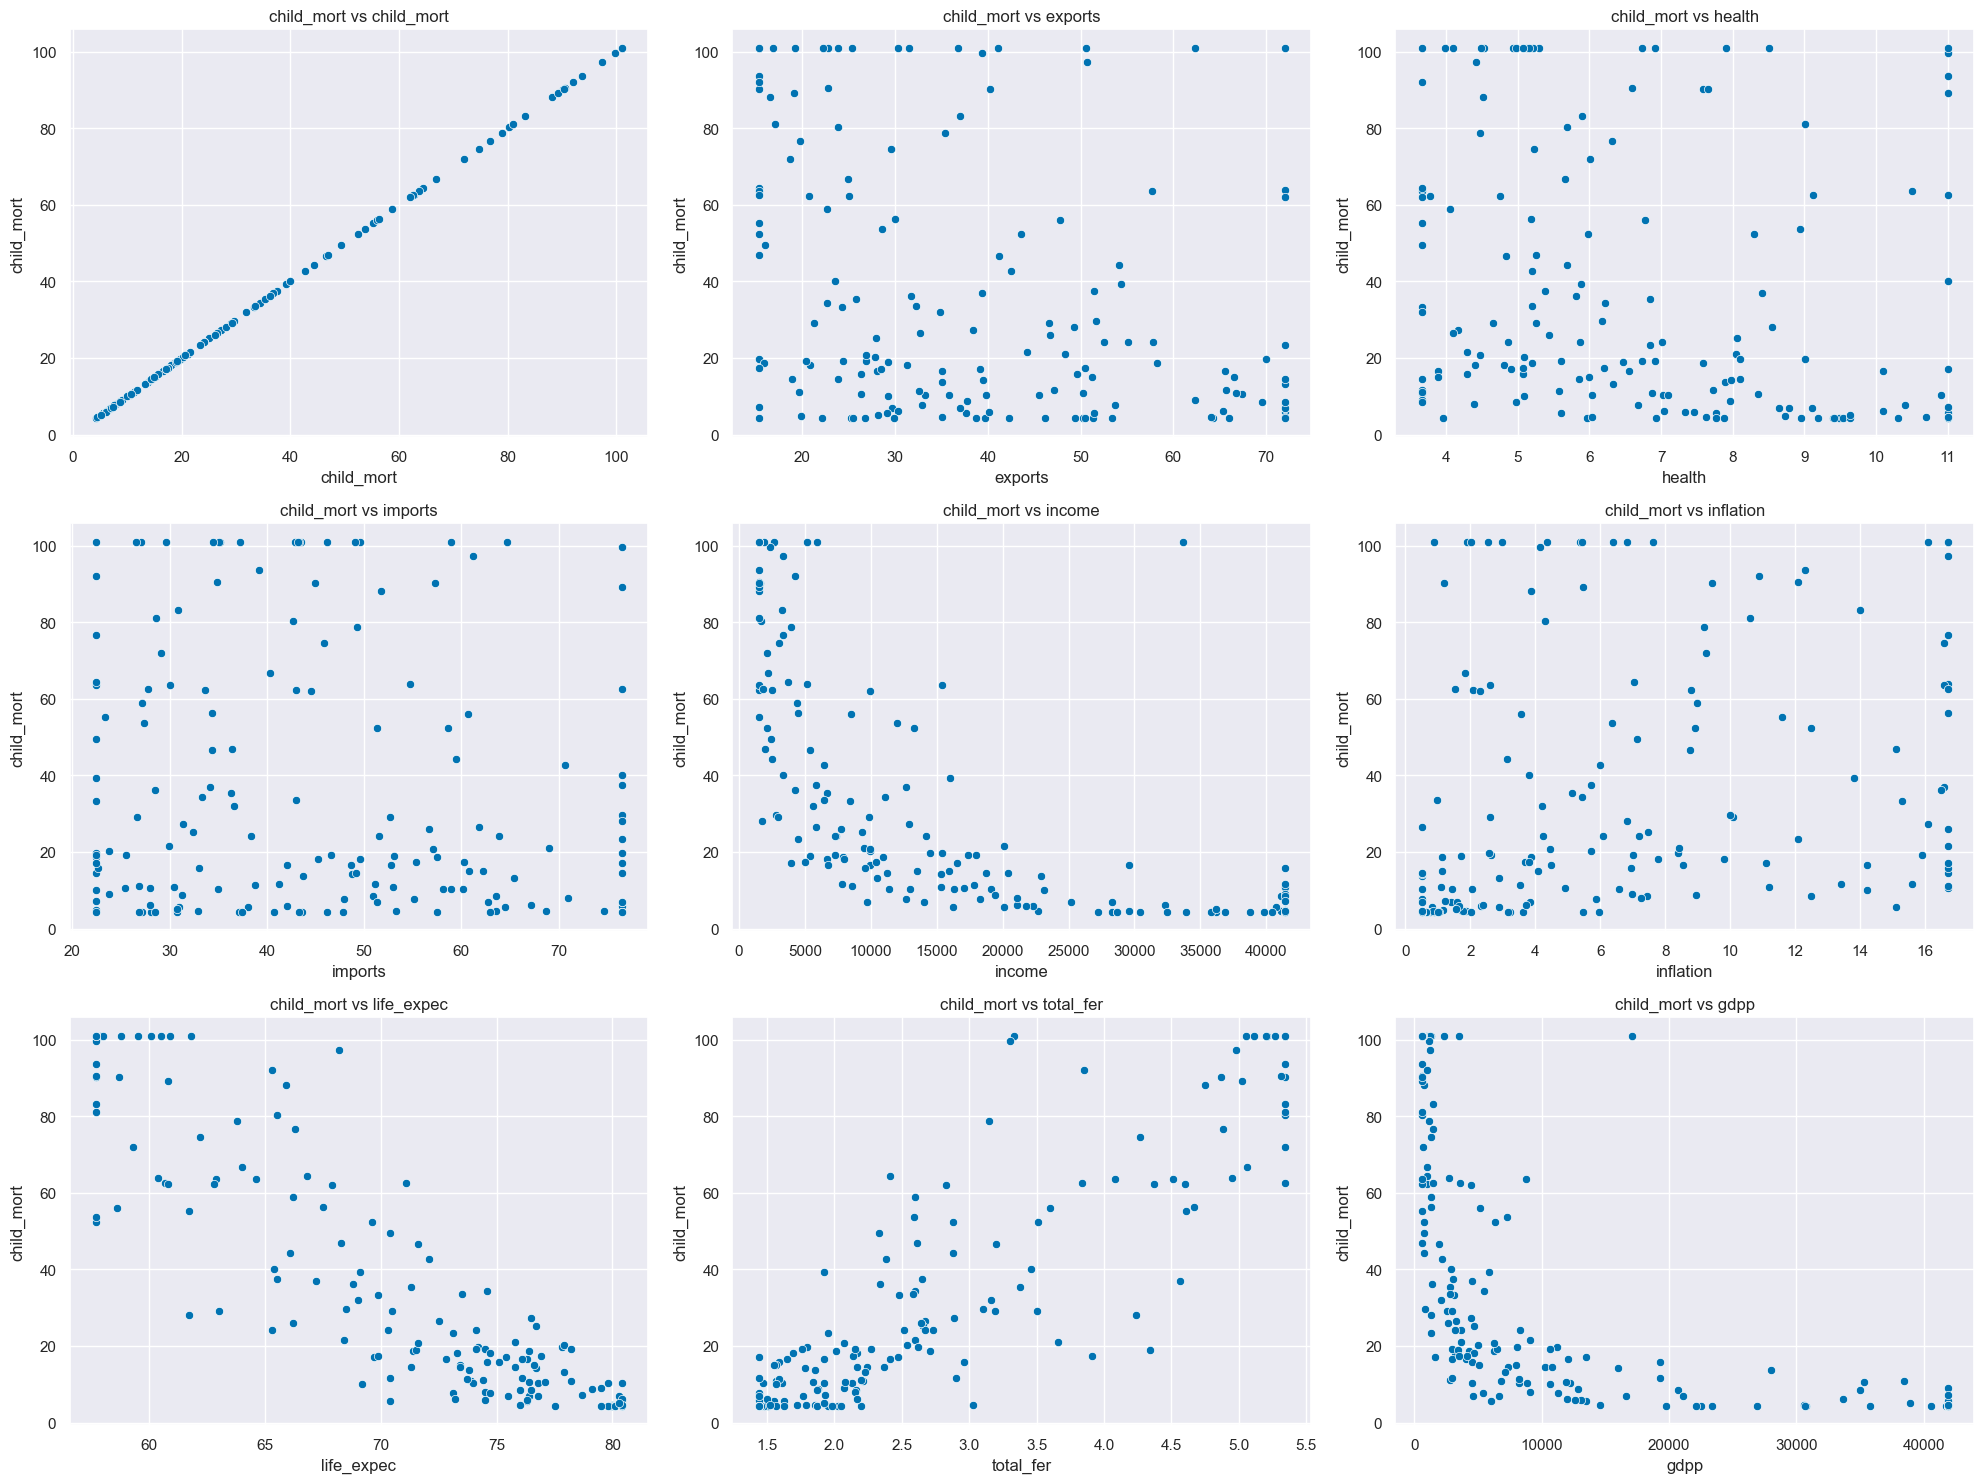

In [554]:
# Explore the continuous independent features against child_mort using scatter plots.

# Set the size of the overall figure
plt.figure(figsize=(20, 15))

# Loop through each feature and create a scatter plot
for i, feature in enumerate(country_df.columns, 1):
    plt.subplot(3, 3, i)  # Adjust subplot layout
    sns.scatterplot(x=country_df[feature], y=country_df['child_mort'])
    plt.title(f'child_mort vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('child_mort')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

From the visualizations above, it appears that Child Mortality has a negative linear correlation with Income, GDP per capita (GDPP), and Life Expectancy, and a positive linear correlation with Total Fertility.

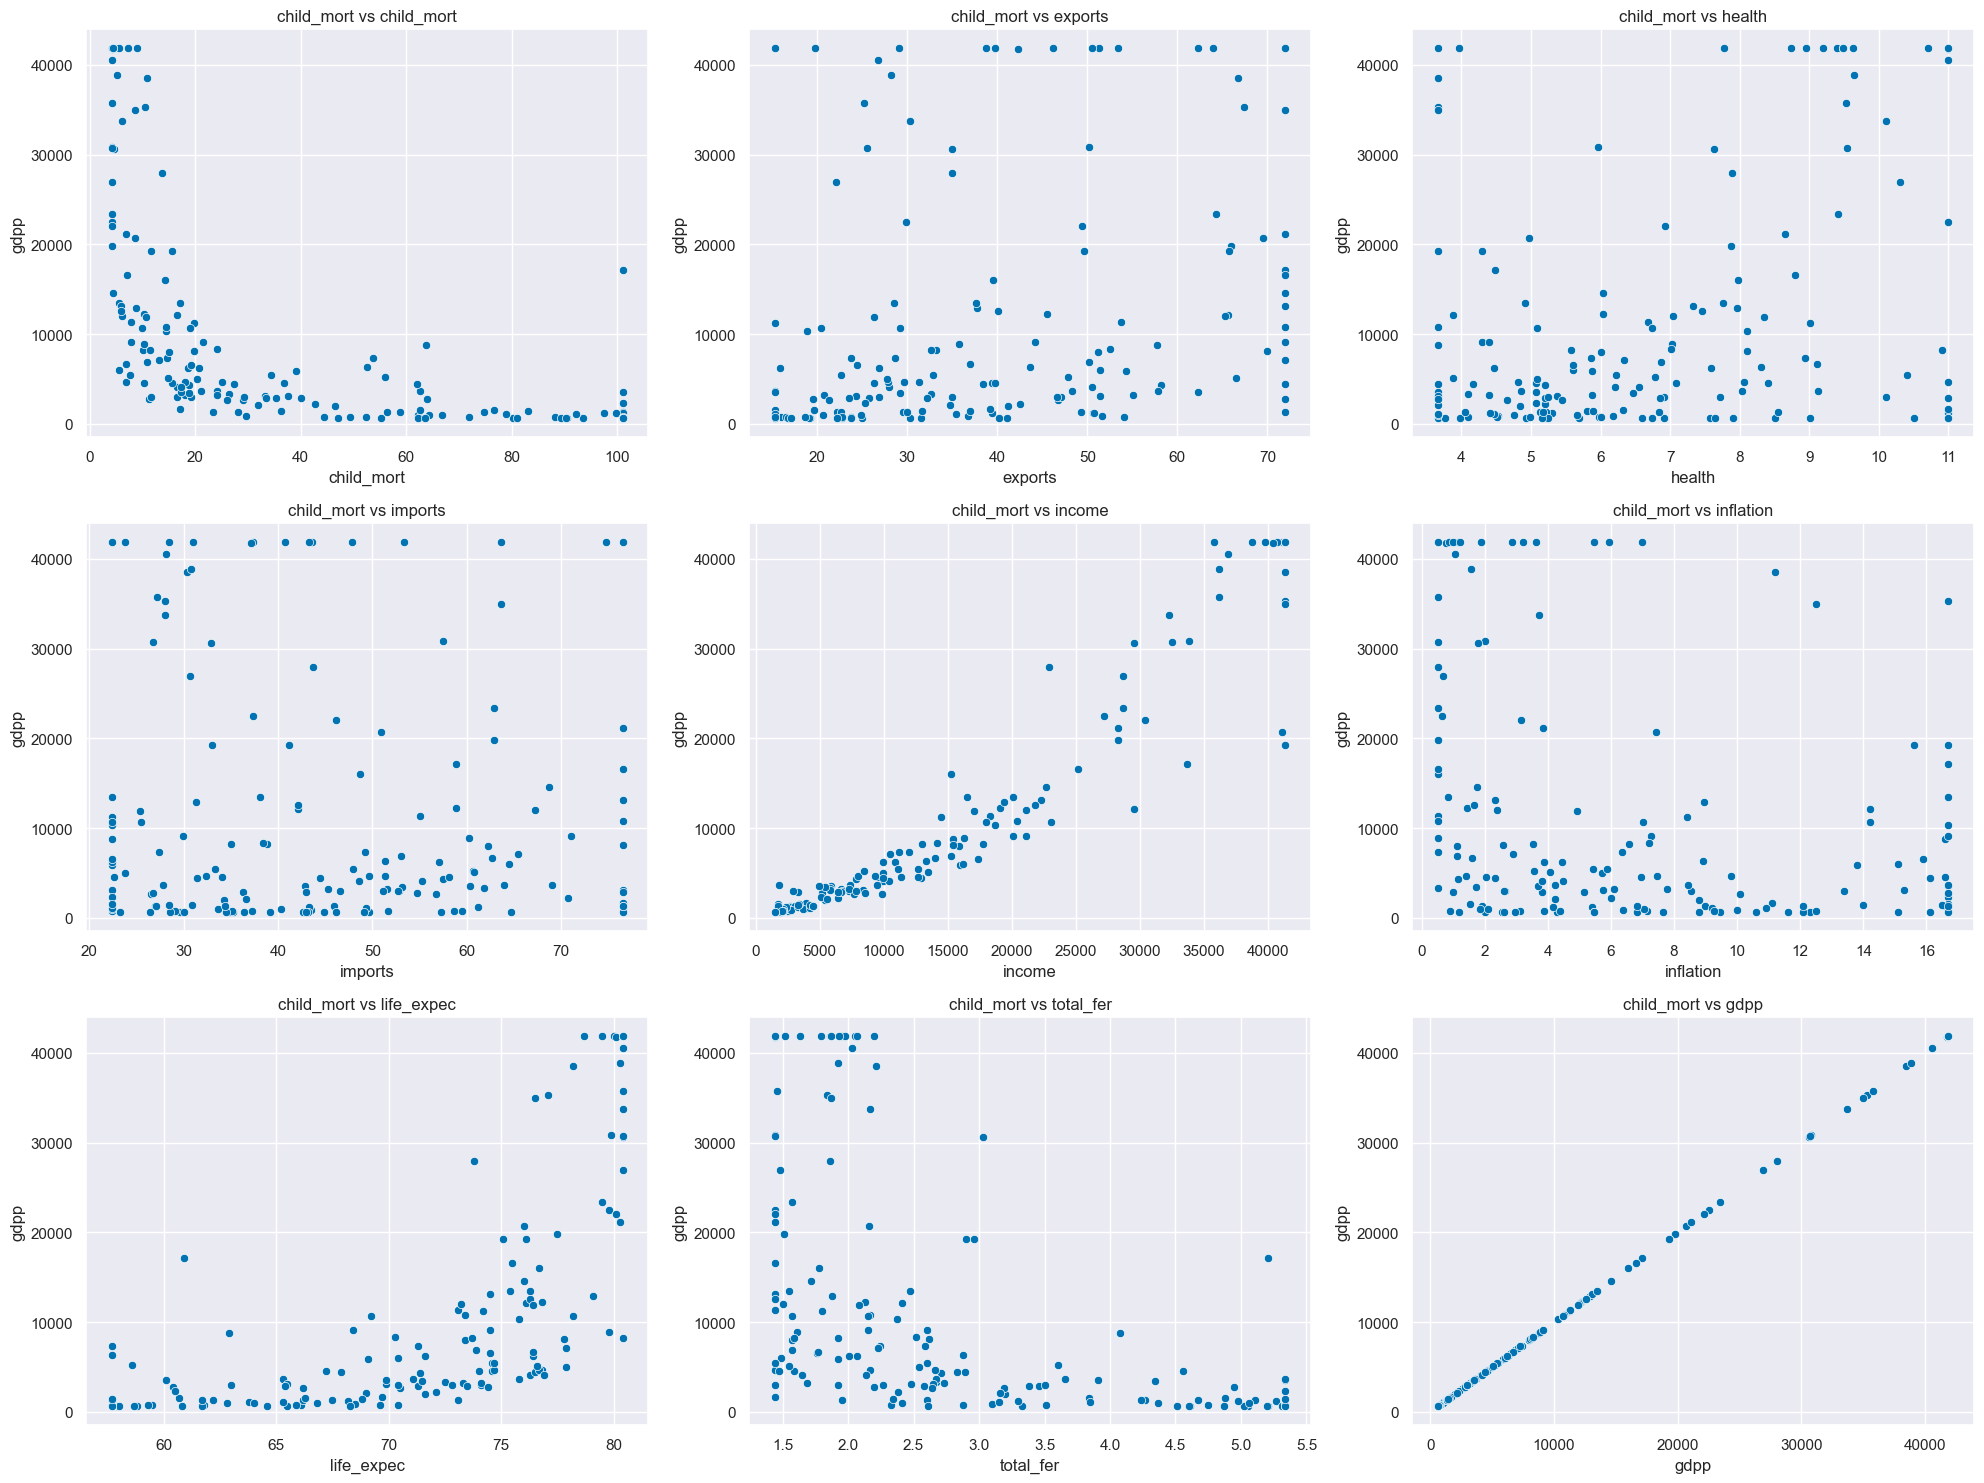

In [555]:
# Explore the continuous independent features against gdpp using scatter plots.

# Set the size of the overall figure
plt.figure(figsize=(20, 15))

# Loop through each feature and create a scatter plot
for i, feature in enumerate(country_df.columns, 1):
    plt.subplot(3, 3, i)  # Adjust subplot layout
    sns.scatterplot(x=country_df[feature], y=country_df['gdpp'])
    plt.title(f'child_mort vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('gdpp')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

Similar to the previous analysis, we observe that GDP per capita (GDPP) has a negative linear correlation with Child Mortality and Total Fertility, and a positive linear correlation with Life Expectancy and Income.

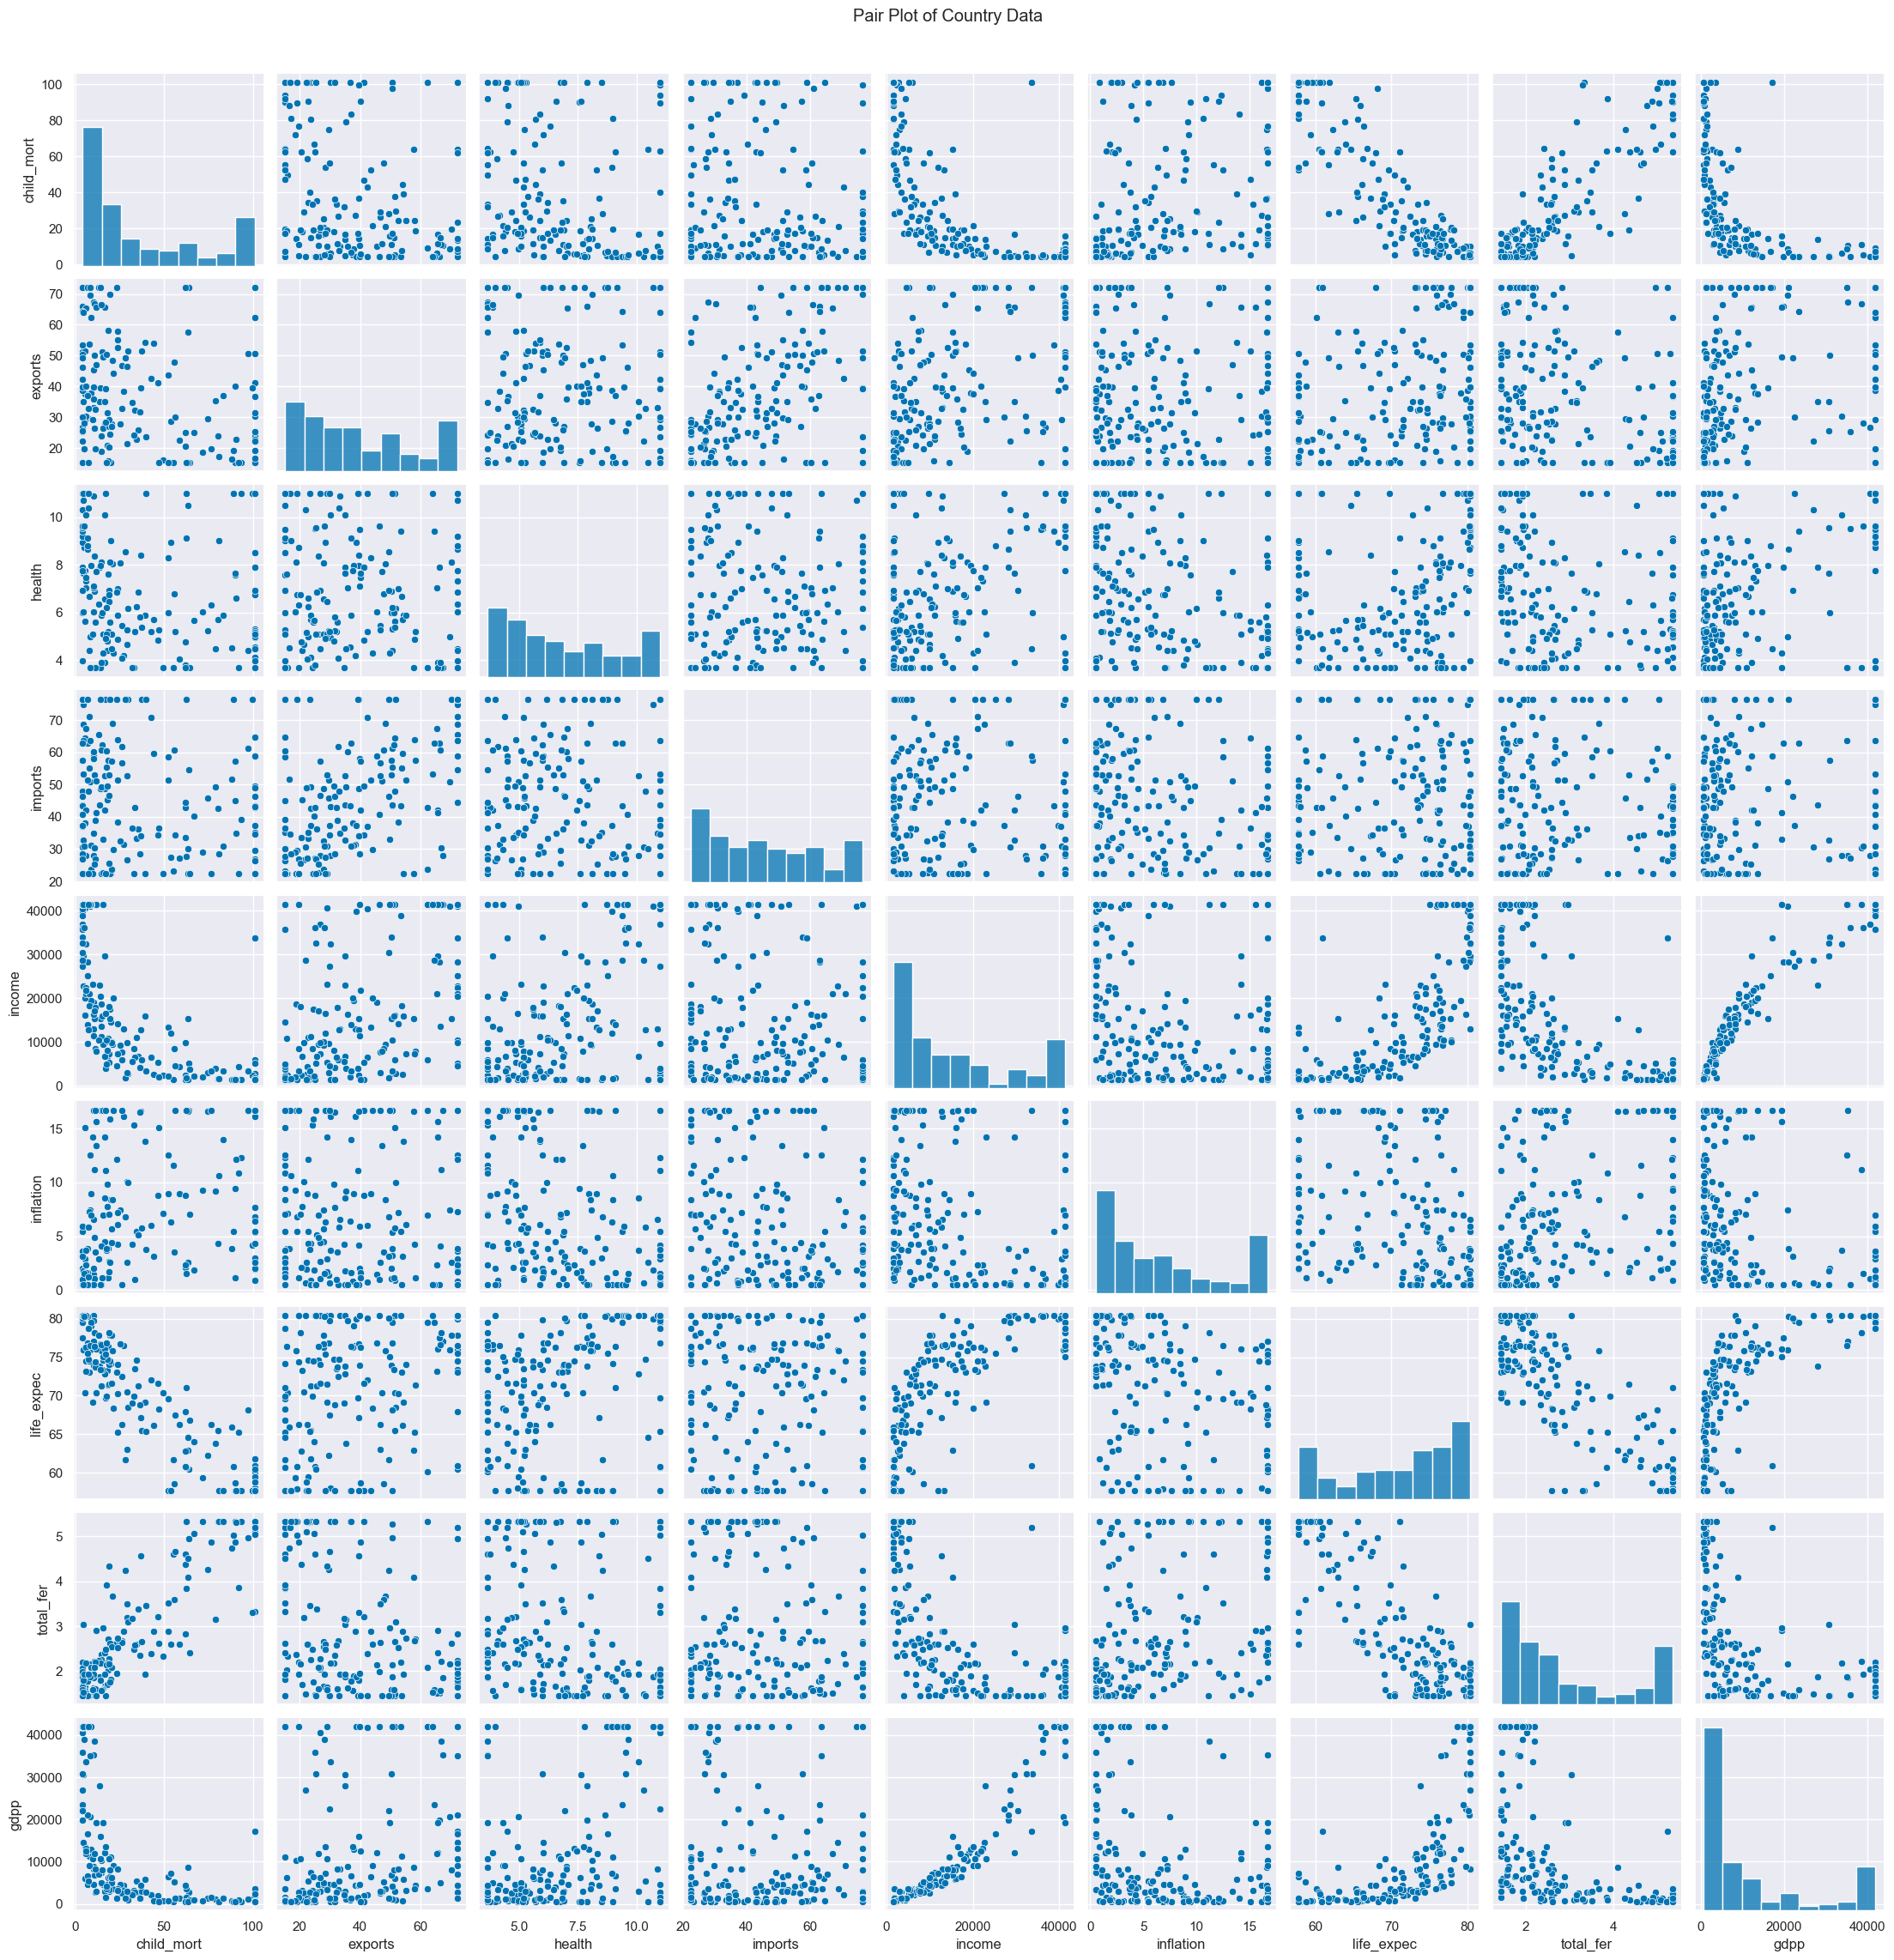

In [556]:
# Create a pair plot

# Set the style and color palette
sns.set(style="darkgrid")  # choose from 'white', 'dark', 'whitegrid', 'darkgrid', 'ticks'
sns.set_palette("colorblind")    # choose from 'deep', 'muted', 'bright', 'pastel', 'dark', 'colorblind', etc.

# Create a pair plot with the specified style and color palette
pair_plot = sns.pairplot(data=country_df)

# Adjust the plot
pair_plot.fig.suptitle('Pair Plot of Country Data', y=1.02)  # Add a title with adjusted position
plt.show()

As shown in the above plots, the following features seem to have linear correlations with each other and can be suitable for training our clustering model:
- exports 
- income
- inflation
- life_expec
- total_fer
- child_mort
- gdpp

### Scaling the Data

In [575]:
# Normalise the data using MinMaxScaler

# Fit the scaler on features
scaler = MinMaxScaler()

# Apply the scaler on features
country_df_scaled = scaler.fit_transform(country_df)
df_scaled = pd.DataFrame(country_df_scaled, columns=country_df.columns)
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.888430,0.000000,0.534060,0.415896,0.002757,0.551713,0.000000,1.000000,0.000000
1,0.128099,0.223986,0.393733,0.484288,0.211278,0.246064,0.819383,0.053846,0.084681
2,0.238636,0.407407,0.069482,0.166359,0.285714,0.962952,0.828194,0.371795,0.093638
3,1.000000,0.828924,0.000000,0.378928,0.110276,1.000000,0.105727,1.000000,0.071124
4,0.063017,0.532628,0.322888,0.674677,0.441103,0.057734,0.841410,0.176923,0.281011


## K-Means Clustering

In [576]:
# include features that have meaningful correlations with each other based on heatmap & pairplot
training_features = ['exports', 'income', 'inflation', 'life_expec', 'total_fer', 'child_mort', 'gdpp']
X = df_scaled[training_features].values.reshape(-1,7)  

print(f'Data size: \n {X.shape}')

Data size: 
 (167, 7)


### Selecting K

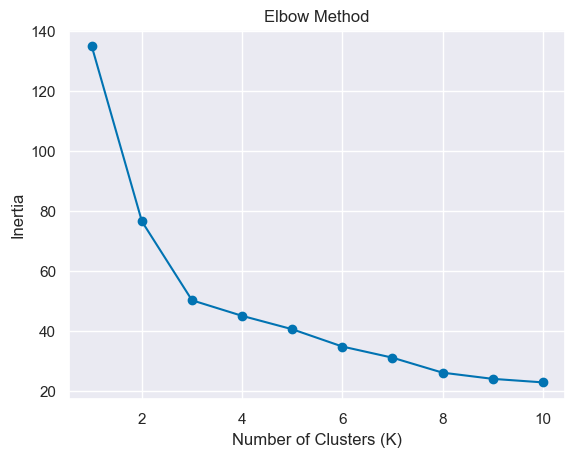

In [577]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.show()

# Plot elbow curve using scaled dataset
elbow_Kmeans(X)

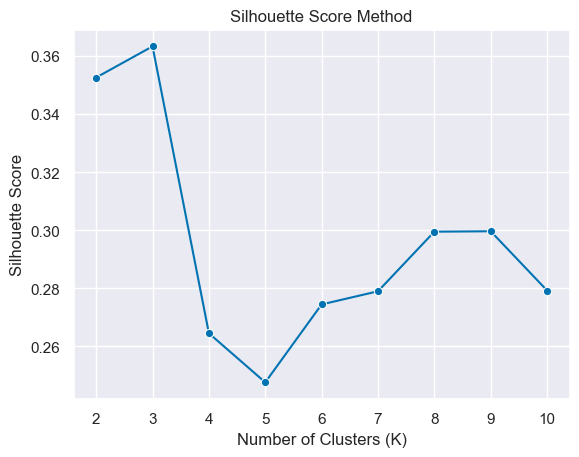

In [578]:
# Silhouette score method
kmax = 10
sil = []
r = 42
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(X)
    labels = kmeans.labels_
    sil.append(silhouette_score(X, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the elbow and silhouette score method the optimal value for K is **3**.

## Fitting a K-Means Model with the selected K value

In [579]:
# Remember to set the random_state to rseed
r = 42

# Train the KMeans model with the optimal number of clusters (3)
kmeans = KMeans(n_clusters=3, random_state=r)
kmeans.fit(X)

KMeans(n_clusters=3, random_state=42)

In [580]:
# Count the number of records in each cluster

# Turn X back into a DataFrame
clustered_df = pd.DataFrame(X, columns=training_features)

# Add the 'Cluster' column to the DataFrame
clustered_df['cluster'] = kmeans.labels_

# # Cluster sizes
clustered_df['cluster'].value_counts()

cluster
0    77
2    49
1    41
Name: count, dtype: int64

The above output indicates the distribution of countries across different clusters:

- Cluster **0**: Contains **77** countries.
- Cluster **1**: Contains **41** countries.
- Cluster **2**: Contains **49** countries.

In [581]:
# Cluster characteristics
clustered_df.groupby('cluster').mean()

,exports,income,inflation,life_expec,total_fer,child_mort,gdpp
cluster,,,,,,,
0,0.415218,0.245966,0.389339,0.667487,0.216317,0.185991,0.126685
1,0.614015,0.869430,0.185748,0.940690,0.098624,0.018167,0.795410
2,0.253536,0.062375,0.539206,0.144475,0.842752,0.798596,0.032458


- Cluster 1 represents **developed** countries with high income, high life expectancy, and low child mortality.
- Cluster 2 comprises **least developed** countries with low income, high child mortality, and low life expectancy.
- Cluster 0 lies between these two extremes, indicating **developing**countries with moderate economic and social indicators.

In [582]:
# Check model performance with the silhouette coefficient
silhouette_score(clustered_df, kmeans.fit_predict(X))

0.5774983700149393

Given a silhouette score of **0.5774983700149393**:

- The score is significantly above 0, indicating that the clusters are reasonably well-defined.
- The data points within each cluster are relatively close to each other and reasonably far from points in other clusters.
- There is still some room for improvement. The clusters are distinct, but not perfectly separated.
  
In summary, the silhouette score suggests that the clustering solution is fairly effective, with clusters that are well-defined and distinct, but not perfect.

## Predictions

In [583]:
# Add the predicted cluster label column to the original dataframe
clustered_df['country'] = countries.values
ordered_columns = ['country', 'cluster'] + [col for col in clustered_df.columns if col not in ['country', 'cluster']]
clustered_df = clustered_df[ordered_columns]
clustered_df.head()

,country,cluster,exports,income,inflation,life_expec,total_fer,child_mort,gdpp
0,Afghanistan,2,0.000000,0.002757,0.551713,0.000000,1.000000,0.888430,0.000000
1,Albania,0,0.223986,0.211278,0.246064,0.819383,0.053846,0.128099,0.084681
2,Algeria,0,0.407407,0.285714,0.962952,0.828194,0.371795,0.238636,0.093638
3,Angola,2,0.828924,0.110276,1.000000,0.105727,1.000000,1.000000,0.071124
4,Antigua and Barbuda,0,0.532628,0.441103,0.057734,0.841410,0.176923,0.063017,0.281011


## Visualisation of clusters

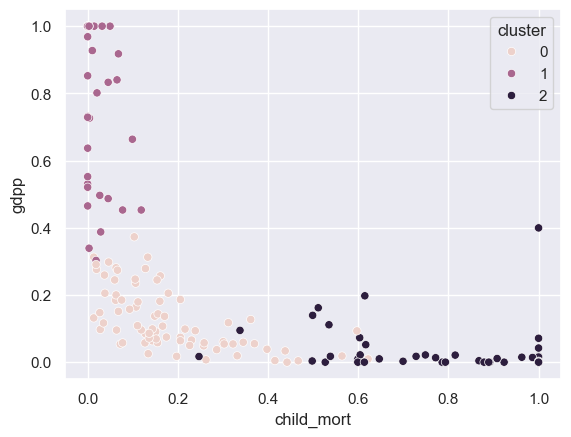

In [584]:
# Visualisation of clusters: child mortality vs gdpp
sns.scatterplot(x='child_mort', y='gdpp', data=clustered_df, hue='cluster')
plt.show() 

In the scatter plot, it's evident that cluster 2 comprises countries with low GDPP and high child mortality rates. The data suggests an inverse relationship between GDPP and child mortality, indicating that higher GDPP correlates with lower likelihood of child deaths.

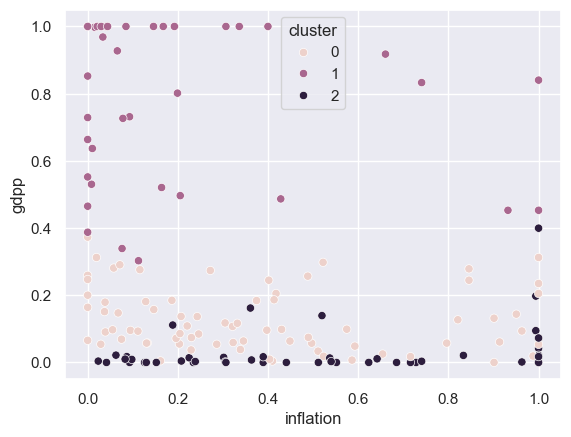

In [585]:
# Visualisation of clusters: inflation vs gdpp
sns.scatterplot(x='inflation', y='gdpp', data=clustered_df, hue='cluster')
plt.show() 

Inflation appears to have minimal impact on GDPP, as the clusters based on this feature are not clearly distinguishable.

## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**

In [586]:
# Give each cluster a name
cluster_names = {
    0: 'Developing',
    1: 'Developed',
    2: 'Least Developed'
}

# Map the cluster names to the 'Cluster' column
clustered_df['cluster'] = clustered_df['cluster'].map(cluster_names)
clustered_df.head()

,country,cluster,exports,income,inflation,life_expec,total_fer,child_mort,gdpp
0,Afghanistan,Least Developed,0.000000,0.002757,0.551713,0.000000,1.000000,0.888430,0.000000
1,Albania,Developing,0.223986,0.211278,0.246064,0.819383,0.053846,0.128099,0.084681
2,Algeria,Developing,0.407407,0.285714,0.962952,0.828194,0.371795,0.238636,0.093638
3,Angola,Least Developed,0.828924,0.110276,1.000000,0.105727,1.000000,1.000000,0.071124
4,Antigua and Barbuda,Developing,0.532628,0.441103,0.057734,0.841410,0.176923,0.063017,0.281011


In [587]:
clustered_df[['country', 'cluster']].drop_duplicates()

,country,cluster
0,Afghanistan,Least Developed
1,Albania,Developing
2,Algeria,Developing
3,Angola,Least Developed
4,Antigua and Barbuda,Developing
...,...,...
162,Vanuatu,Developing
163,Venezuela,Developing
164,Vietnam,Developing
165,Yemen,Least Developed


In [591]:
clustered_df[clustered_df.cluster == 'Developed'].tail(10)

,country,cluster,exports,income,inflation,life_expec,total_fer,child_mort,gdpp
133,Singapore,Developed,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
134,Slovak Republic,Developed,1.000000,0.593985,0.000000,0.784141,0.000000,0.028926,0.387528
135,Slovenia,Developed,0.864198,0.681704,0.000000,0.960352,0.033333,0.000000,0.552145
138,South Korea,Developed,0.601411,0.724311,0.163939,0.986784,0.000000,0.000000,0.520674
139,Spain,Developed,0.179894,0.776942,0.000000,1.000000,0.000000,0.000000,0.728866
144,Sweden,Developed,0.544974,1.000000,0.030009,1.000000,0.138462,0.000000,1.000000
145,Switzerland,Developed,0.858907,1.000000,0.000000,1.000000,0.020513,0.003099,1.000000
157,United Arab Emirates,Developed,1.000000,1.000000,0.740661,0.828194,0.110256,0.045455,0.832962
158,United Kingdom,Developed,0.227513,0.869674,0.065761,0.995595,0.123077,0.010331,0.927375
159,United States,Developed,0.000000,1.000000,0.044149,0.925110,0.125641,0.032025,1.000000


**Least Developed Countries:**

- Afghanistan, Angola, Yemen, Zambia, and potentially others fall into this category.
- These countries typically exhibit low levels of economic development, high poverty rates, inadequate infrastructure, limited access to healthcare and education, and high child mortality rates.
- Factors contributing to their classification may include low income levels, high child mortality rates, low life expectancy, and other socio-economic indicators associated with underdevelopment.

**Developing Countries:**

- Albania, Algeria, Antigua and Barbuda, Vanuatu, Venezuela, Vietnam, and potentially others are classified as developing.
- Developing countries typically show signs of economic growth, improvements in infrastructure, healthcare, education, and other social indicators.
- While they may still face challenges, they demonstrate progress toward achieving higher levels of development compared to LDCs.
- Features like moderate income levels, relatively lower child mortality rates, and improving socio-economic conditions may contribute to their categorization.
- This categorization aligns with the common understanding of development status based on socio-economic indicators. However, the specific features and thresholds used in the clustering model would influence the classification outcome, so it's essential to review the input features and their significance in the clustering process to fully justify the results.

**Developed Countries:**
- Developed countries typically have high per capita income levels, indicating strong economic performance and wealth distribution among the population.
- The countries listed, including Australia, Austria, Belgium, Canada, Denmark, Finland, Germany, Japan, Netherlands, Norway, Singapore, Sweden, Switzerland, United Kingdom, and United States, consistently rank among the world's highest-income nations.